In [284]:
import numpy as np
import pandas as pd  # library for dataframes
import numpy as np
import datetime      # library for dates
import matplotlib.pyplot as plt     # library for plotting
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.font_manager as font_manager
import seaborn as sns
from helper_function import preprocessing
from tueplots import bundles
from tueplots.constants.color import rgb

In [101]:
# Setting parameters for the plotting libraries
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Microsoft Sans Serif'
plt.rc('axes', labelsize=18)            # fontsize of the x and y labels
plt.rc('xtick', labelsize=17)           # fontsize of the tick labels
plt.rc('ytick', labelsize=17)           # fontsize of the tick labels
plt.rc('legend', fontsize=17)           # legend fontsize
plt.rc('font', size=17)                 # controls default text sizes
plt.rc('font', family='serif', serif='Times New Roman')
sns.set_style('whitegrid')
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

In [333]:
# Setting important variables
data_path = 'anonymized.csv'
date_format = '%d.%m.%Y'
resolution = 600
date_form = DateFormatter(date_format)
custom_order = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']
custom_order_eng = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_mapping = {'Mo': 'Mon', 'Di': 'Tue', 'Mi': 'Wed', 'Do': 'Thu', 'Fr': 'Fri', 'Sa': 'Sat', 'So': 'Sun'}

In [334]:
# Loading dataset and preprocessing
data = pd.read_csv(data_path)
# Preprocessing the data
data = preprocessing(data_frame=data, date_format=None)
data

,weekday,date,duration(in h),pseudonym,sex,machine
0,Mo,2022-12-05,1.0,F1,f,2
1,Mo,2022-12-05,1.0,F2,f,2
2,Di,2022-12-06,1.0,M1,m,1
3,Di,2022-12-06,1.5,M2,m,1
4,Di,2022-12-06,1.0,M3,m,1
...,...,...,...,...,...,...
2341,Mo,2023-12-04,1.0,M36,m,2
2342,Mo,2023-12-04,1.0,M7,m,2
2343,Mo,2023-12-04,1.0,M1,m,2
2344,Mo,2023-12-04,1.0,M44,m,1


In [335]:
def sum_usage_per_day(df):
    '''
    Summing up the usage time per day per data point.
    :param df (pd.DataFrame):
    :return:
    '''
    daily_usage = df.groupby('date')['duration(in h)'].sum()
    return daily_usage

In [336]:
daily_usage = sum_usage_per_day(data.copy())
# Calculate moving average with a window size of 7 days
moving_average = daily_usage.rolling(window=7).mean()
average = daily_usage.mean()
deviation = abs(average - daily_usage).rolling(window=7).mean()

In [337]:
# Setting start and end date
start_date = data['date'][0]
end_date = data['date'][2345]
# Setting dates of the semester breaks
xmas_start = datetime.datetime(2022, 12, 23)
xmas_end = datetime.datetime(2023, 1, 7)
ss_start = datetime.datetime(2023, 4, 17)
ss_end = datetime.datetime(2023, 7, 29)
easter_start = datetime.datetime(2023, 5, 29)
easter_end = datetime.datetime(2023, 6, 3)
ws_start = datetime.datetime(2023, 9, 16)
ws_end = datetime.datetime(2023, 2, 11)

In [338]:
# Defining the opacity for the mark of the semester breaks
opacity = 0.2

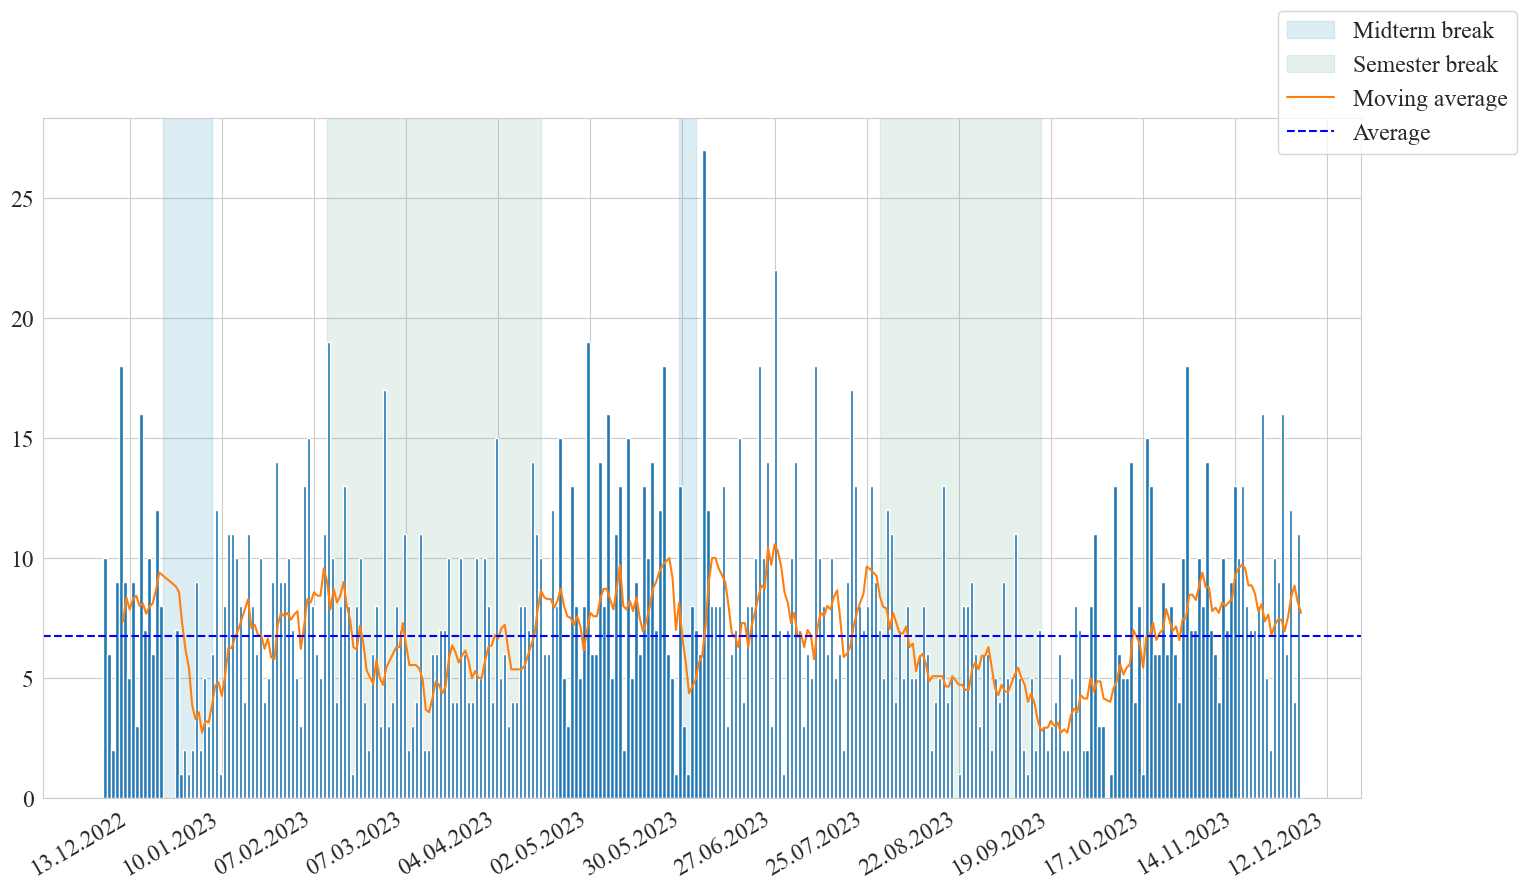

In [339]:
fig, ax = plt.subplots(figsize=(17, 10))
# Plotting break times
ax.axvspan(xmin=xmas_start, xmax=xmas_end, alpha=opacity, color=rgb.tue_lightblue, label='Midterm break')
ax.axvspan(xmin=easter_start, xmax=easter_end, alpha=opacity, color=rgb.tue_lightblue)
ax.axvspan(xmin=ws_end, xmax=ss_start, color=rgb.tue_lightgreen, alpha=opacity, label='Semester break')
ax.axvspan(xmin=ss_end, xmax=ws_start, color=rgb.tue_lightgreen, alpha=opacity)
#
ax.xaxis.set_major_formatter(date_form)
# making histogram
n, bins, patches = ax.hist(data['date'], bins=300, range=(start_date, end_date), width=1.0)
# Ensure ticks fall once every other week (interval=4)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
# plot moving average and total average
ax.plot(moving_average, label='Moving average')
ax.axhline(y=average, color='blue', linestyle='--', label='Average')
fig.autofmt_xdate()
fig.legend()
fig.savefig('data-for-year.png', dpi=resolution)

In [340]:
occupancy_per_weekday = data.copy().groupby(['sex', 'weekday']).size()
all_occupancy = data.copy().groupby(['weekday']).size()
male_occupancy = occupancy_per_weekday.copy().loc['m'].reset_index(name='occurrences')
female_occupancy = occupancy_per_weekday.copy().loc['f'].reset_index(name='occurrences')

In [341]:
# Group data by 'sex' and 'weekday', count occurrences, and reshape the result
absolute_values = data.groupby(['sex', 'weekday']).size().unstack(level=0).fillna(0).astype(int)

# Reorder the DataFrame based on 'custom_order' and melt it for the desired structure
absolute_values = absolute_values.loc[custom_order].reset_index().melt(id_vars='weekday', var_name='Gender', value_name='Count')

# Set the 'weekday' column as a categorical with the custom order
absolute_values['weekday'] = pd.Categorical(absolute_values['weekday'], categories=custom_order, ordered=True)
absolute_values.rename(columns={'weekday': 'Day'}, inplace=True)

absolute_values['Day'] = absolute_values['Day'].replace(day_mapping)
absolute_values = absolute_values[absolute_values['Gender'] != 'u']
absolute_values['Gender'] = absolute_values['Gender'].replace({'f': 'Females', 'm' : 'Males'})

In [342]:
# Transform datasets to a probability distribution
male_occupancy['occurrences'] /= male_occupancy['occurrences'].sum()
female_occupancy['occurrences'] /= female_occupancy['occurrences'].sum()
all_occupancy /= all_occupancy.sum()
all_occupancy = all_occupancy.reset_index(name='occurrences')

# Convert 'weekday' column to Categorical with custom order and sort by 'weekday'
for df in [male_occupancy, female_occupancy, all_occupancy]:
    df['weekday'] = pd.Categorical(df.weekday, categories=custom_order, ordered=True)
    df.sort_values('weekday', inplace=True)

# Preparing dataframe for English day representation
df = pd.DataFrame({'Day': custom_order_eng, 'Males': list(male_occupancy['occurrences']),
                   'Females': list(female_occupancy['occurrences']), 'All': list(all_occupancy['occurrences'])}, index=custom_order)

# Melt the dataframe to create a "gender" column
df_melted = pd.melt(df, id_vars=['Day'], value_vars=['Females', 'Males', 'All'], var_name='Gender', value_name='Percentage')
df_melted.Percentage = df_melted.Percentage * 100

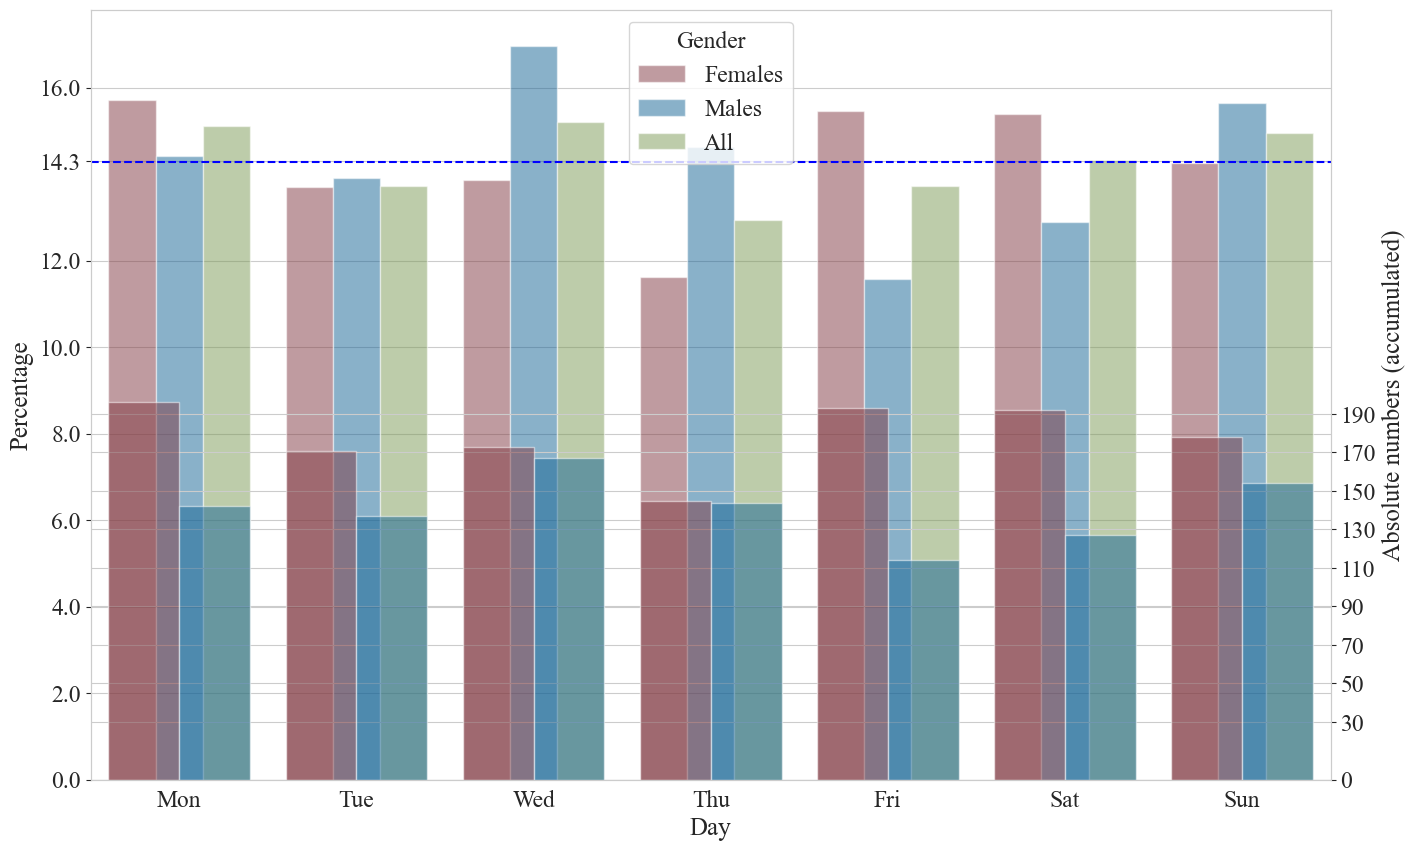

In [343]:
fig, ax = plt.subplots(figsize=(16, 10))
# Plotting using Seaborn
ax = sns.barplot(x='Day', y='Percentage', hue='Gender', data=df_melted, palette={'Females': rgb.tue_red, 'Males': rgb.tue_blue, 'All': rgb.tue_green}, alpha=0.5)
ax.axhline(y=100/7, color='blue', linestyle='--')
ax.set_yticks([0.0, 2, 4, 6, 8, 10, 12, 14.3, 16])
ax2 = ax.twinx()
ax2.set_ylim([0, 400])
ax2.set_yticks([0, 30, 50, 70, 90, 110, 130, 150, 170, 190])
ax2 = sns.barplot(x='Day', y='Count', hue='Gender', data=absolute_values, alpha=0.5, palette={'Females': rgb.tue_red, 'Males': rgb.tue_blue})
ax2.legend_.remove()
ax2.set_ylabel('Absolute numbers (accumulated)')
fig.savefig('Data_per_weekday.png', dpi=resolution)